In [1]:
import torch
import torch.nn as nn
from torch.functional import F
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import re
from collections import Counter
import random
from IPython.display import clear_output
import math
from tag2desc import tag2desc
from zipfile import ZipFile

# Download

In [2]:
!kaggle datasets download -d nltkdata/penn-tree-bank

penn-tree-bank.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
with ZipFile('penn-tree-bank.zip', 'r') as z:
    z.extractall()

# Load into notebook

In [4]:
path = Path('.')
path_comb = path/"treebank"/"treebank"/"combined"
path_comb

PosixPath('treebank/treebank/combined')

In [5]:
files = [o for o in path_comb.iterdir()]

In [6]:
files.pop(0)

PosixPath('treebank/treebank/combined/README')

In [7]:
combineds = [file.open().read() for file in files]

This is what the labeled documents look like:

In [8]:
combineds[1]

'\n( (S \n    (NP-SBJ-1 \n      (NP (NNP Rudolph) (NNP Agnew) )\n      (, ,) \n      (UCP \n        (ADJP \n          (NP (CD 55) (NNS years) )\n          (JJ old) )\n        (CC and) \n        (NP \n          (NP (JJ former) (NN chairman) )\n          (PP (IN of) \n            (NP (NNP Consolidated) (NNP Gold) (NNP Fields) (NNP PLC) ))))\n      (, ,) )\n    (VP (VBD was) \n      (VP (VBN named) \n        (S \n          (NP-SBJ (-NONE- *-1) )\n          (NP-PRD \n            (NP (DT a) (JJ nonexecutive) (NN director) )\n            (PP (IN of) \n              (NP (DT this) (JJ British) (JJ industrial) (NN conglomerate) ))))))\n    (. .) ))\n'

I'll extract only the parts of speech tags and the words, which are contained in the innermost pairs of parentheses:

In [9]:
def get_pairs(texts):
    all_pairs = []
    for text in texts:
        pairs = re.findall(r'\((\S+) (\S+)\)', text)
        all_pairs += pairs
    return all_pairs

In [10]:
all_pairs = get_pairs(combineds)
len(all_pairs)

100676

I'll remove the tag "-NONE-" because it represents the absence of a word, and is not really a part-of-speech tag:

In [11]:
all_pairs = [[tag,tok] for tag,tok in all_pairs if tag != '-NONE-']
len(all_pairs)

94084

In [12]:
all_pairs[:10]

[['NNP', 'Pierre'],
 ['NNP', 'Vinken'],
 [',', ','],
 ['CD', '61'],
 ['NNS', 'years'],
 ['JJ', 'old'],
 [',', ','],
 ['MD', 'will'],
 ['VB', 'join'],
 ['DT', 'the']]

Now I'll separate them into a list of all tags and a list of all tokens:

In [13]:
tags,toks = list(zip(*all_pairs))

In [14]:
tags[:10]

('NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT')

In [15]:
toks[:10]

('Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the')

# Descriptions

A descriptive string for each tag abbreviation can be found [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

I've already created and imported a python file containing a dictionary that maps abbreviations to descriptions, so I'll create a corresponding list of descriptions:

In [16]:
descs = [tag2desc[tag] if tag in tag2desc.keys() else '' for tag in tags]

# Explore by tag

In [17]:
df = pd.DataFrame({'Token':toks, 'Tag':tags, 'Description':descs})

In [18]:
len(df)

94084

In [19]:
tag_counts = df[['Tag', 'Token']].groupby(['Tag']).agg(['count'])['Token']['count'].sort_values(ascending=False)
tag_counts[:10]

Tag
NN     13166
IN      9857
NNP     9410
DT      8165
NNS     6047
JJ      5834
,       4886
.       3874
CD      3546
VBD     3043
Name: count, dtype: int64

The total count of the top 20 tags in the dataset:

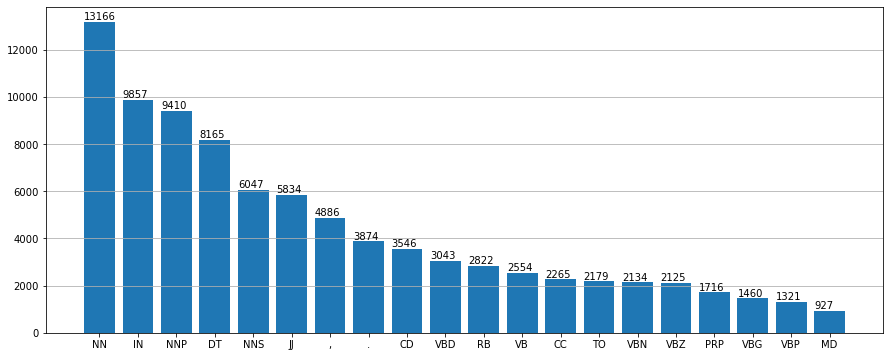

In [20]:
tc = tag_counts[:20]
heights = tc.values
labels = tc.index
plt.figure(figsize=(15,6))
plt.bar(range(len(tc)), heights, tick_label=labels)
for x,y in enumerate(heights):
    plt.text(x-.4,y+100,str(y))
plt.grid(axis='y')
plt.show()

Each of those tags as a percentage of all tags in the dataset:

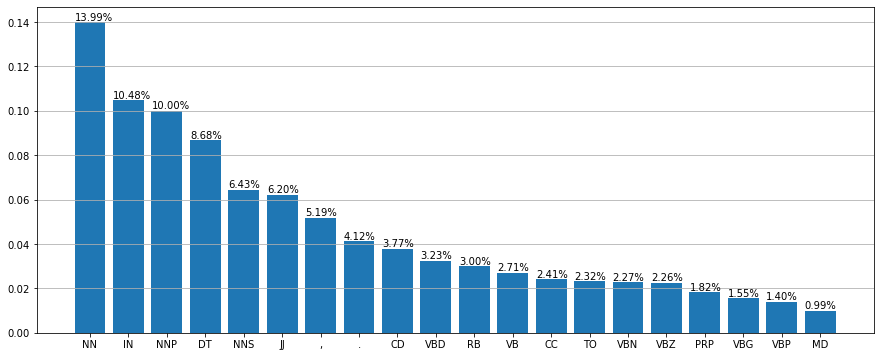

In [113]:
total_tags = tag_counts.sum()
tc = tag_counts[:20]
heights = tc.values / total_tags
labels = tc.index
plt.figure(figsize=(15,6))
plt.bar(range(len(tc)), heights, tick_label=labels)
for x,y in enumerate(heights):
    plt.text(x-.4,y+.001,f"{y*100:.2f}%")
plt.grid(axis='y')
plt.show()

Here's what would happen if we predicted most of the tags correctly:

In [125]:
(tag_counts['IN'] + tag_counts['DT'] + tag_counts[6:].sum()) / tag_counts.sum()

0.6337634454317419

# Tag Categories

## Verb, base form

It's hard to recognize a verb in base form by its spelling alone:

In [21]:
VBs = df[df['Tag']=='VB']['Token'].unique()
VBs[:50]

array(['join', 'make', 'bring', 'be', 'support', 'regulate', 'have',
       'recognize', 'slide', 'indicate', 'retain', 'capture', 'blip',
       'pour', 'vary', 'go', 'obtain', 'complete', 'issue', 'lift',
       'raise', 'act', 'default', 'oversee', 'treat', 'prove', 'expand',
       'return', 'remain', 'keep', 'introduce', 'increase', 'cost',
       'announce', 'reward', 'shore', 'justify', 'acquire', 'suffer',
       'come', 'take', 'withdraw', 'speed', 'refile', 'refund', 'begin',
       'entertain', 'block', 'force', 'slash'], dtype=object)

They are hard to distinguish from singular/mass nouns based on spelling:

## Noun, singular or mass

In [22]:
NNs = df[df['Tag']=='NN']['Token'].unique()
NNs[:50]

array(['board', 'director', 'chairman', 'group', 'conglomerate', 'form',
       'asbestos', 'cigarette', 'percentage', 'cancer', 'fiber',
       'crocidolite', 'unit', 'Micronite', 'year', 'today', 'forum',
       'attention', 'problem', 'spokewoman', 'story', 'anyone',
       'research', 'information', 'risk', 'team', 'spokeswoman', 'paper',
       'type', 'filter', 'company', 'substance', 'number', 'total',
       'mesothelioma', 'lung', 'asbestosis', 'morbidity', 'rate',
       'finding', 'factory', 'plant', 'contract', 'Lorillard', 'class',
       'kind', 'chrysotile', 'standard', 'regulation', 'professor'],
      dtype=object)

Actually, many words are both verbs and nouns:

In [23]:
np.intersect1d(VBs, NNs)[:50]

array(['account', 'act', 'address', 'advance', 'aid', 'aim', 'answer',
       'appeal', 'attack', 'attempt', 'audit', 'back', 'ban', 'bar',
       'benefit', 'block', 'book', 'boost', 'buffet', 'buy', 'call',
       'care', 'catch', 'cause', 'challenge', 'change', 'charge', 'claim',
       'close', 'color', 'command', 'comment', 'compromise', 'concern',
       'conduct', 'contract', 'control', 'cost', 'crack', 'cut', 'deal',
       'debate', 'decline', 'decrease', 'default', 'defeat', 'delay',
       'demand', 'design', 'drop'], dtype=object)

On the other hand, some verb forms are easy to identify by spelling:

## Gerunds

Gerunds are verbs in the form ending in "ing":

In [24]:
gerunds = df[df['Tag']=='VBG']['Token']
gerunds.unique()[:50]

array(['publishing', 'causing', 'using', 'talking', 'having', 'making',
       'surviving', 'including', 'according', 'remaining', 'declining',
       'rising', 'yielding', 'waiving', 'holding', 'cutting',
       'manufacturing', 'receiving', 'boarding', 'Knowing', 'looking',
       'reflecting', 'casting', 'trying', 'maintaining', 'increasing',
       'paying', 'doing', 'gaining', 'According', 'saying', 'raising',
       'seeking', 'operating', 'appealing', 'underlying', 'considering',
       'tracking', 'collecting', 'involving', 'setting', 'arising',
       'diversifying', 'pending', 'providing', 'working', 'needing',
       'beginning', 'being', 'transferring'], dtype=object)

In fact, there are no gerunds that *don't* end in "ing" or "ING":

In [25]:
gerunds[~gerunds.str.match(r'^.+ing$', case=False)]

Series([], Name: Token, dtype: object)

## Verb, past tense

In [26]:
VBDs = df[df['Tag']=='VBD']['Token']
VBDs.unique()[:50]

array(['was', 'reported', 'said', 'stopped', 'were', 'heard', 'studied',
       'led', 'worked', 'explained', 'imposed', 'made', 'dumped',
       'poured', 'mixed', 'described', 'hung', 'ventilated', 'contracted',
       'took', 'continued', 'eased', 'ended', 'lengthened', 'reached',
       'rose', 'grew', 'had', 'fell', 'slid', 'resigned', 'approved',
       'completed', 'suspended', 'dropped', 'settled', 'decided',
       'joined', 'followed', 'raced', 'welcomed', 'hauled', 'drooled',
       'pointed', 'squeezed', 'fed', 'gave', 'registered', 'released',
       'showed'], dtype=object)

Most past tense verbs end in "ed". Here are the only ones that *don't* end in "ed":

In [27]:
VBDs[~VBDs.str.match(r'^.+ed$', case=False)].unique()

array(['was', 'said', 'were', 'heard', 'made', 'hung', 'took', 'rose',
       'grew', 'had', 'fell', 'slid', 'gave', 'stood', 'began', 'spent',
       'did', 'got', 'upheld', 'found', 'set', 'came', 'met', 'became',
       'cut', 'bought', 'went', 'ran', 'sold', 'shot', 'brought', 'hid',
       'paid', 'won', 'left', 'dreamt', 'taught', 'told', 'meant',
       'broke', 'thought', 'read', 'bid', 'saw', 'leapt', 'lost',
       'understood', 'wrote', 'lay', 'sent', 'held', 'begot', 'felt',
       'stuck', 'kept', 'spoke', 'drove', 'fought', 'knew', 'chose',
       'underwent', 'put', 'let', 'have', 'wound', 'built', 'beat',
       'sought', 'drew', 'rang', 'withdrew', 'forecast', 'lent', 'hit',
       'shrank', 'befell', 'sank'], dtype=object)

The same is true here as well:

## Verb, past participle 

In [28]:
VBNs = df[df['Tag']=='VBN']['Token']
VBNs.unique()[:50]

array(['named', 'used', 'caused', 'exposed', 'reported', 'replaced',
       'sold', 'died', 'expected', 'diagnosed', 'studied',
       'industrialized', 'owned', 'found', 'classified', 'rejected',
       'outlawed', 'imported', 'tracked', 'thought', 'considered',
       'elected', 'based', 'lifted', 'ensnarled', 'voted', 'been', 'held',
       'banned', 'renovated', 'prolonged', 'recorded', 'accumulated',
       'offered', 'become', 'guaranteed', 'proposed', 'related',
       'improved', 'worried', 'cluttered', 'expedited', 'retired',
       'ordered', 'collected', 'required', 'received', 'moved',
       'determined', 'made'], dtype=object)

Again, the ones that don't end in "ed":

In [29]:
VBNs[~VBNs.str.match(r'^.+ed$', case=False)].unique()

array(['sold', 'found', 'thought', 'been', 'held', 'become', 'made',
       'set', 'paid', 'forgiven', 'built', 'brought', 'left', 'put',
       'cast', 'repaid', 'lent', 'fallen', 'spent', 'broken', 'written',
       'run', 'had', 'laid', 'given', 'taken', 'come', 'caught', 'Stung',
       'grown', 'gotten', 'known', 'seen', 'gone', 'chosen', 'got',
       'withdrawn', 'lost', 'heard', 'sent', 'UPHELD', 'kept', 'offset',
       'said', 'met', 'hit', 'spread', 'shown', 'frozen', 'done', 'rung',
       'drawn', 'risen', 'Put', 'forgotten', 'sought', 'Given', 'hurt',
       'upset', 'understood', 'read', 'won', 'shut', 'torn', 'staid',
       'begun', 'upheld', 'shaken', 'proven', 'beaten', 'Left', 'cut',
       'overcome', 'hidden', 'overdone', 'bought', 'meant', 'own', 'felt',
       'split', 'told', 'forecast', 'spun', 'born'], dtype=object)

Some tags have so few unique tokens that they could just be memorized:

## Preposition or subordinating conjunction

In [30]:
df[df['Tag']=='IN']['Token'].unique()

array(['as', 'of', 'among', 'than', 'ago', 'once', 'with', 'in',
       'Although', 'about', 'before', 'on', 'whether', 'at', 'from',
       'for', 'From', 'Among', 'by', 'under', 'that', 'In', 'By', 'About',
       'into', 'over', 'though', 'amid', 'since', 'because', 'Despite',
       'during', 'after', 'Until', 'until', 'if', 'like', 'On', 'along',
       'For', 'so', 'After', 'Under', 'while', 'far', 'between', 'per',
       'without', 'out', 'below', 'worth', 'against', 'around',
       'complicated', 'off', 'through', 'near', 'although', 'While',
       'Besides', 'up', 'Along', 'Without', 'At', 'including', 'So',
       'During', 'via', 'despite', 'throughout', 'outside', 'above',
       'Unlike', 'Behind', 'As', 'If', 'unless', 'to', 'except', 'Of',
       'behind', 'Before', 'across', 'But', 'unlike', 'and', 'Against',
       'toward', 'Because', 'a', 'Since', 'Over', 'OVER', 'next', 'are',
       '@', 'down', 'With', 'which', 'within', 'upon', 'de', 'Unless',
       'Like', '

## Determiner

In [31]:
df[df['Tag']=='DT']['Token'].unique()

array(['the', 'a', 'this', 'A', 'The', 'This', 'an', 'any', 'no',
       'Neither', 'those', 'all', 'some', 'these', 'No', 'another',
       'that', 'Both', 'That', 'each', 'every', 'half', 'All', 'both',
       'These', 'Those', 'An', 'Another', 'neither', 'Any', 'Each',
       'Some', 'THE', 'la', 'le', 'Every', 'del', 'either', 'AN'],
      dtype=object)

## End of Sentence

In [32]:
df[df['Tag']=='.']['Token'].unique()

array(['.', '?', '!'], dtype=object)

## Cardinal number

Numbers can usually be recognized by the presence of digit characters:

In [33]:
CDs = df[df['Tag']=='CD']
CDs['Token'].unique()[:50]

array(['61', '29', '55', '30', '1956', '1950s', '1953', '1955', '9.8',
       'billion', '33', '28', 'three', 'Four', 'five', '18', 'one',
       '1997', '160', '35', '400', '8.45', '8.47', '41', '8.04', '7.90',
       '1.5', '352.7', '9', '9.37', '9.45', '8.12', '8.14', '8.19',
       '8.22', '8.53', '8.56', '83.4', 'seven', '27', '212', 'million',
       '295', '2,700', '370', '2.80', 'trillion', '2.87', '3.1', '43'],
      dtype=object)

However, some only contain letters:

In [34]:
CDs[CDs['Token'].str.match(r'^[a-zA-Z]+$')]['Token'].unique()

array(['billion', 'three', 'Four', 'five', 'one', 'seven', 'million',
       'trillion', 'four', 'two', 'nine', 'six', 'Three', 'THREE', 'One',
       'IX', 'FIRST', 'the', 'hundred', 'Five', 'Fifteen', 'Nine', 'Ten',
       'Two', 'eight', 'TWO', 'thousand', 'zero', 'Fourteen'],
      dtype=object)

# Sentences

In [36]:
def get_sentences(pairs):
    sentences = []
    sentence = []
    for tag,tok in all_pairs:
        sentence.append([tag,tok])
        if tag == '.':
            sentences.append(sentence)
            sentence = []
    return sentences

In [37]:
sentences = get_sentences(all_pairs)

In [56]:
statements = [sentence for sentence in sentences if sentence[-1][-1]=='.']
len(statements)

3828

In [57]:
statements[0]

[['NNP', 'Pierre'],
 ['NNP', 'Vinken'],
 [',', ','],
 ['CD', '61'],
 ['NNS', 'years'],
 ['JJ', 'old'],
 [',', ','],
 ['MD', 'will'],
 ['VB', 'join'],
 ['DT', 'the'],
 ['NN', 'board'],
 ['IN', 'as'],
 ['DT', 'a'],
 ['JJ', 'nonexecutive'],
 ['NN', 'director'],
 ['NNP', 'Nov.'],
 ['CD', '29'],
 ['.', '.']]

In [42]:
questions = [sentence for sentence in sentences if sentence[-1][-1]=='?']
len(questions)

40

In [59]:
questions[1]

[['``', '``'],
 ['NN', 'Anything'],
 ['VBZ', "'s"],
 ['JJ', 'possible'],
 [':', '--'],
 ['WRB', 'how'],
 ['RP', 'about'],
 ['DT', 'the'],
 ['NNP', 'New'],
 ['NNP', 'Guinea'],
 ['NNP', 'Fund'],
 ['.', '?']]

In [48]:
exclamations = [sentence for sentence in sentences if sentence[-1][-1]=='!']
len(exclamations)

6

In [55]:
exclamations[1]

[['VBP', 'Do'],
 ['RB', "n't"],
 ['VB', 'wait'],
 [':', '--'],
 ['DT', 'a'],
 ['NNS', 'savings'],
 ['NN', 'institution'],
 ['VBZ', 'needs'],
 ['PRP$', 'your'],
 ['NN', 'help'],
 ['RB', 'now'],
 ['.', '!']]

In [60]:
tag_sentences = [[tag for tag,tok in sentence] for sentence in sentences]

In [70]:
tag_sentences[0]

['NNP',
 'NNP',
 ',',
 'CD',
 'NNS',
 'JJ',
 ',',
 'MD',
 'VB',
 'DT',
 'NN',
 'IN',
 'DT',
 'JJ',
 'NN',
 'NNP',
 'CD',
 '.']

In [71]:
tok_sentences = [[tok for tag,tok in sentence] for sentence in sentences]

In [72]:
tok_sentences[0]

['Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov.',
 '29',
 '.']

In [73]:
assert len(tag_sentences)==len(tok_sentences)